In [2]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/geom2vec/results/chignolin_stride10'
preprocess = Preprocessing(torch_or_numpy='torch')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r')
# we concatenate the data of the same trajectory
dataset = torch.cat(raw_dataset).to(torch.float32)
del raw_dataset
time_lagged_dataset = preprocess.create_time_lagged_dataset(dataset.to(torch.float32), lag_time=10)
print(time_lagged_dataset[0][0].shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 532.08it/s]


torch.Size([10, 4, 128])


In [3]:
from torch.utils.data.dataloader import DataLoader

train_data, val_data = torch.utils.data.random_split(time_lagged_dataset, [int(0.8*len(time_lagged_dataset)), len(time_lagged_dataset)-int(0.8*len(time_lagged_dataset))])

print('train_data:', len(train_data))
print('val_data:', len(val_data))

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

train_data: 42772
val_data: 10693


In [4]:
train_data[0][0].shape

torch.Size([10, 4, 128])

In [14]:
from geom2vec import Lobe
from geom2vec.downstream_models import VAMPNet
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Lobe(
    hidden_channels=128,
    intermediate_channels=128,
    output_channels=2,
    num_layers=2,
    batch_norm=False,
    vector_feature=True,
    mlp_dropout=0.1,
    mlp_out_activation=None,
    token_mixer = 'submixer',
    num_mixer_layers = 4,
    pooling = 'sum',
    dropout = 0.1,
    num_tokens = 10,
    token_dim = 36,
    device=device
)

model = VAMPNet(
    lobe=net,
    learning_rate=1e-4,
    device=device
)

model.fit(train_loader,n_epochs=10,validation_loader=val_loader,progress=tqdm)



epoch:  10%|███████████▎                                                                                                     | 1/10 [00:01<00:16,  1.82s/it]

0 1.8604505062103271



epoch:  20%|██████████████████████▌                                                                                          | 2/10 [00:03<00:14,  1.82s/it]

1 1.8987623453140259



epoch:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:05<00:12,  1.82s/it]

2 1.9259262084960938



epoch:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:07<00:10,  1.81s/it]

3 1.9184858798980713



epoch:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:09<00:09,  1.82s/it]

4 1.9310908317565918



epoch:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:10<00:07,  1.82s/it]

5 1.9325813055038452



epoch:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:12<00:05,  1.82s/it]

6 1.9325469732284546



epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:14<00:03,  1.83s/it]

7 1.9330191612243652



epoch:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:16<00:01,  1.85s/it]

8 1.9344004392623901



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 26.89it/s]
                                                                                                                                                            

9 1.933182716369629


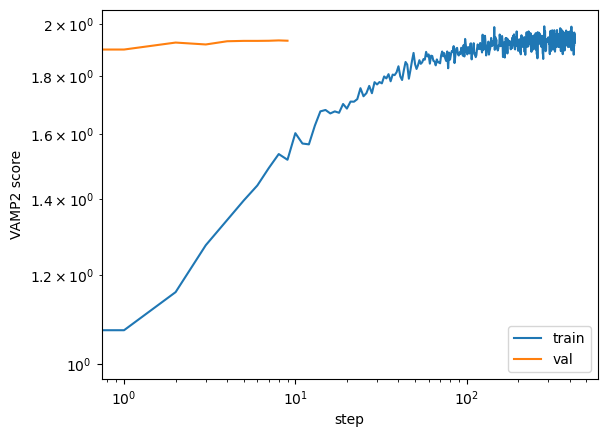

In [15]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('VAMP2 score')
plt.legend()
plt.show()

In [16]:
cvs = model.transform(dataset,return_cv=True,lag_time=10,batch_size=1000)
cvs.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 157.92it/s]


(53475, 2)

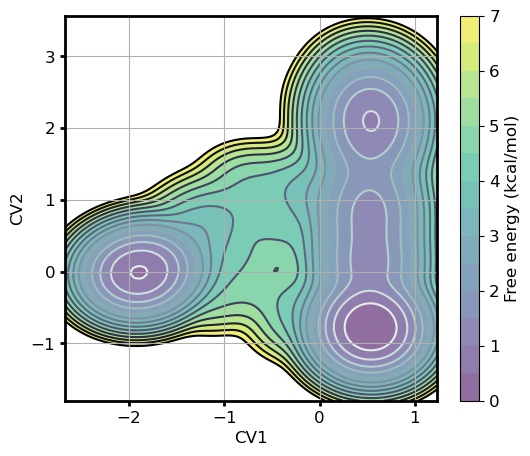

In [17]:
from geom2vec.utils import ContourPlot2D

fig,ax = plt.subplots(1,1,figsize=(6,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_tick_params(labelsize=12,direction='out',width=2)
ax.yaxis.set_tick_params(labelsize=12,direction='out',width=2)
c = ContourPlot2D()
ax = c.plot(cvs[:,0:2][::5],ax,labelsize=12,xlabel='CV1',ylabel='CV2')

# don't just use that little data, use all the data, and you don't need any token mixer for chignolin